In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from numpy import unique, where
import matplotlib.pyplot as plt

import os
os.chdir('../../')

from modules import preproc
from modules.join_data import join_y
from modules import feature_eng
from modules import cluster_intelligence
from modules.evaluate_model import get_eval_scores
from modules.dbscan_grid_search import run_dbscan_gs, get_best_models
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows',150)
pd.set_option('display.max_columns',1000)

## Reading in data and preproc

In [2]:
# laptops
laptops = pd.read_json('full_data/laptops.json')
laptops = join_y(laptops, 'raw_data/laptops_sales.csv')
laptops = preproc.clean_cols(laptops)
laptops = preproc.fill_empty_lists(laptops)
laptops = preproc.preprocess_reviews(laptops)
laptops = feature_eng.generate_features(laptops)
laptops = feature_eng.do_PCA(laptops)
laptops['TOTAL_SALES_QBINNED'] = pd.qcut(laptops['TOTAL_SALES'], 3, labels=[0,1,2])

# phones
phones = pd.read_json('full_data/smartphones.json')
phones = join_y(phones, 'raw_data/phone_sales.csv')
phones = preproc.clean_cols(phones)
phones = preproc.fill_empty_lists(phones)
phones = preproc.preprocess_reviews(phones)
phones = feature_eng.generate_features(phones)
phones = feature_eng.do_PCA(phones)
phones['TOTAL_SALES_QBINNED'] = pd.qcut(phones['TOTAL_SALES'], 3, labels=[0,1,2])
# desktops
desktops = pd.read_json('full_data/desktops.json')
desktops = join_y(desktops, 'raw_data/desktops_sales.csv')
desktops = preproc.clean_cols(desktops)
desktops = preproc.fill_empty_lists(desktops)
desktops = preproc.preprocess_reviews(desktops)
desktops = feature_eng.generate_features(desktops)
desktops = feature_eng.do_PCA(desktops)
desktops['TOTAL_SALES_QBINNED'] = pd.qcut(desktops['TOTAL_SALES'], 3, labels=[0,1,2])
# tablets
tablets = pd.read_json('full_data/tablets.json')
tablets = join_y(tablets, 'raw_data/tablet_sales.csv')
tablets = tablets[tablets['no_reviews'].notna()]
tablets = preproc.clean_cols(tablets)
tablets = preproc.fill_empty_lists(tablets)
tablets = preproc.preprocess_reviews(tablets)
tablets = feature_eng.generate_features(tablets)
tablets = feature_eng.do_PCA(tablets)
tablets['TOTAL_SALES_QBINNED'] = pd.qcut(tablets['TOTAL_SALES'], 3, labels=[0,1,2])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]    

## Scaling

In [3]:
laptops = laptops.select_dtypes(include=['float', 'int64','int32','float64'])
laptops['price/Rvol'] = laptops['price/Rvol'].replace(np.inf, laptops['price/Rvol'].median())
for col in laptops.columns:
    laptops[col] = laptops[col].replace(np.nan, laptops[col].median())
laptops = (laptops-laptops.mean())/laptops.std()

laptops = feature_eng.get_y_true(laptops)



In [4]:
phones = phones.select_dtypes(include=['float', 'int64','int32','float64'])
phones['price/Rvol'] = phones['price/Rvol'].replace(np.inf, phones['price/Rvol'].median())
for col in phones.columns:
    phones[col] = phones[col].replace(np.nan, phones[col].median())
phones = (phones-phones.mean())/phones.std()

phones = feature_eng.get_y_true(phones)


In [5]:
tablets = tablets.select_dtypes(include=['float', 'int64','int32','float64'])
tablets['price/Rvol'] = tablets['price/Rvol'].replace(np.inf, tablets['price/Rvol'].median())
for col in tablets.columns:
    tablets[col] = tablets[col].replace(np.nan, tablets[col].median())
tablets = (tablets-tablets.mean())/tablets.std()

tablets = feature_eng.get_y_true(tablets)


In [6]:
desktops = desktops.select_dtypes(include=['float', 'int64','int32','float64'])
desktops['price/Rvol'] = desktops['price/Rvol'].replace(np.inf, desktops['price/Rvol'].median())
for col in desktops.columns:
    desktops[col] = desktops[col].replace(np.nan, desktops[col].median())
desktops = (desktops-desktops.mean())/desktops.std()

desktops = feature_eng.get_y_true(desktops)


## TOP 3 features

In [7]:
laptops.name = 'laptops'
desktops.name = 'desktops'
phones.name = 'phones'
tablets.name = 'tablets'

In [8]:
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['no_reviews','Rvol/%rec','pos_reviews'],
    epsilon_range = [x / 100.0 for x in range(20, 150, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=250
)

In [12]:
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,combined_score
0,0.599567,0.680619,1.20,5,0.640093
0,0.599567,0.680619,1.20,5,0.640093
0,0.586310,0.680619,1.15,4,0.633464
0,0.586310,0.680619,1.10,3,0.633464
0,0.586310,0.680619,1.10,5,0.633464
0,0.586310,0.680619,1.30,2,0.633464
0,0.586310,0.680619,1.15,2,0.633464
0,0.586310,0.680619,1.15,4,0.633464
0,0.586310,0.680619,1.25,2,0.633464
0,0.586310,0.680619,1.20,4,0.633464


In [24]:
def evaluate_clusters(
    predicted_y,
    real_y,
):
    """Evaluates clustering results, uses silouette and rand if specified. Cannot be used with DBSCAN"""
    sns.kdeplot(predicted_y, real_y.astype(int), shade=True,shade_lowest=True,cbar=True)
    plt.title('Cluster labels with total sales')

## laptops

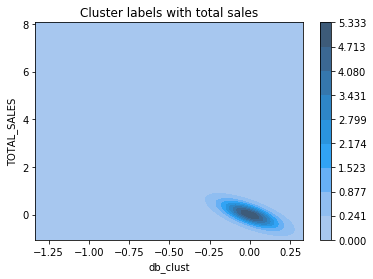

In [25]:
dbscan_model = DBSCAN(eps=1.2, min_samples=(len(laptops))/5)
db_clust = dbscan_model.fit_predict(laptops[['no_reviews','Rvol/%rec','pos_reviews']])
laptops['db_clust'] = pd.Series(db_clust, index=laptops.index)
evaluate_clusters(laptops['db_clust'] ,laptops['TOTAL_SALES'])

In [16]:
cluster_intelligence.cluster_report(laptops[['no_reviews','Rvol/%rec','pos_reviews']],db_clust)

,class_name,instance_count,rule_list
1,-1,7,NaN
0,0,105,[0.9375] ALL


In [17]:
get_eval_scores(laptops['y_true'], laptops['db_clust'])

(1.0, 0.875)

In [18]:
print(laptops.loc[laptops.db_clust==-1]['TOTAL_SALES'].mean())
print(laptops.loc[laptops.db_clust==-0]['TOTAL_SALES'].mean())

2.692044580497955
-0.17946963869986365


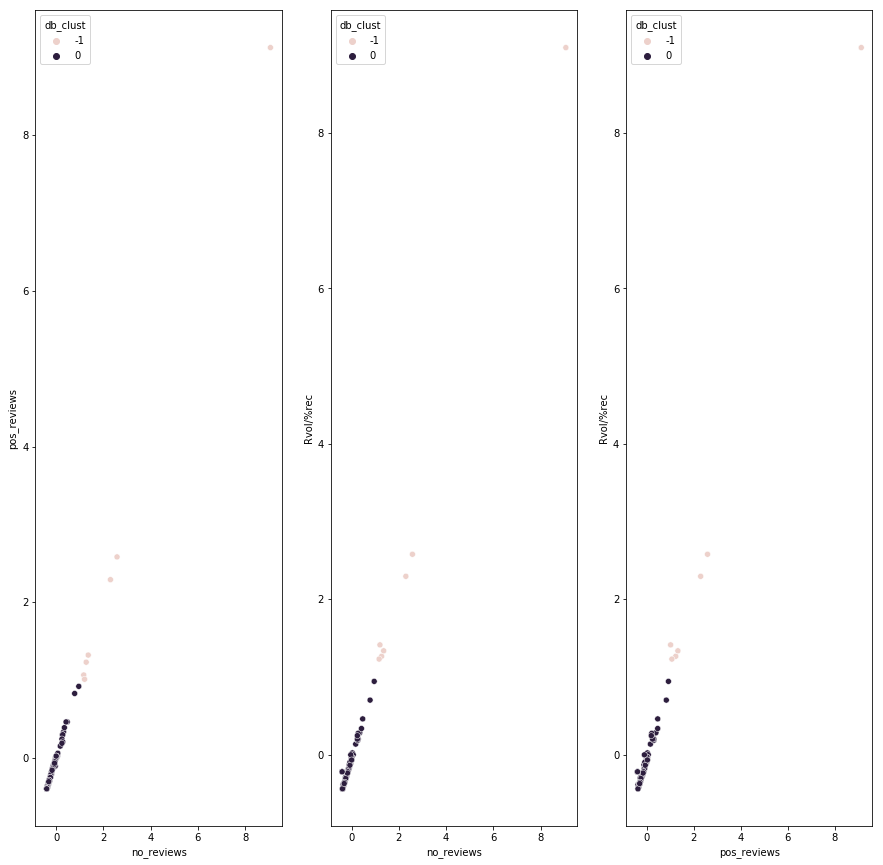

In [19]:
laptops['db_clust'] = pd.Series(db_clust, index=laptops.index)
f, axes = plt.subplots(1,3, figsize=(15,15))
sns.scatterplot(x=laptops['no_reviews'], y=laptops['pos_reviews'], hue=laptops['db_clust'],ax=axes[0])
sns.scatterplot(x=laptops['no_reviews'], y=laptops['Rvol/%rec'],hue=laptops['db_clust'], ax=axes[1])
sns.scatterplot(x=laptops['pos_reviews'], y=laptops['Rvol/%rec'],hue=laptops['db_clust'], ax=axes[2])

## phones

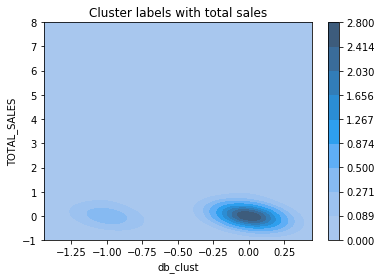

In [26]:

dbscan_model = DBSCAN(eps=1.2, min_samples=(len(phones))/5)
db_clust = dbscan_model.fit_predict(phones[['no_reviews','Rvol/%rec','pos_reviews']])
phones['db_clust'] = pd.Series(db_clust, index=phones.index)
evaluate_clusters(phones['db_clust'] ,phones['TOTAL_SALES'])

In [28]:
cluster_intelligence.cluster_report(phones[['no_reviews','Rvol/%rec','pos_reviews']],db_clust)

,class_name,instance_count,rule_list
1,-1,42,[0.84] (Rvol/%rec > 0.4552217721939087)
0,0,213,[1.0] (Rvol/%rec <= 0.4552217721939087)


In [29]:
get_eval_scores(phones['y_true'], phones['db_clust'])

(0.2619047619047619, 0.6111111111111112)

In [30]:
print(phones.loc[phones.db_clust==-1]['TOTAL_SALES'].mean())
print(phones.loc[phones.db_clust==-0]['TOTAL_SALES'].mean())

0.8610308822060502
-0.1697807373364042


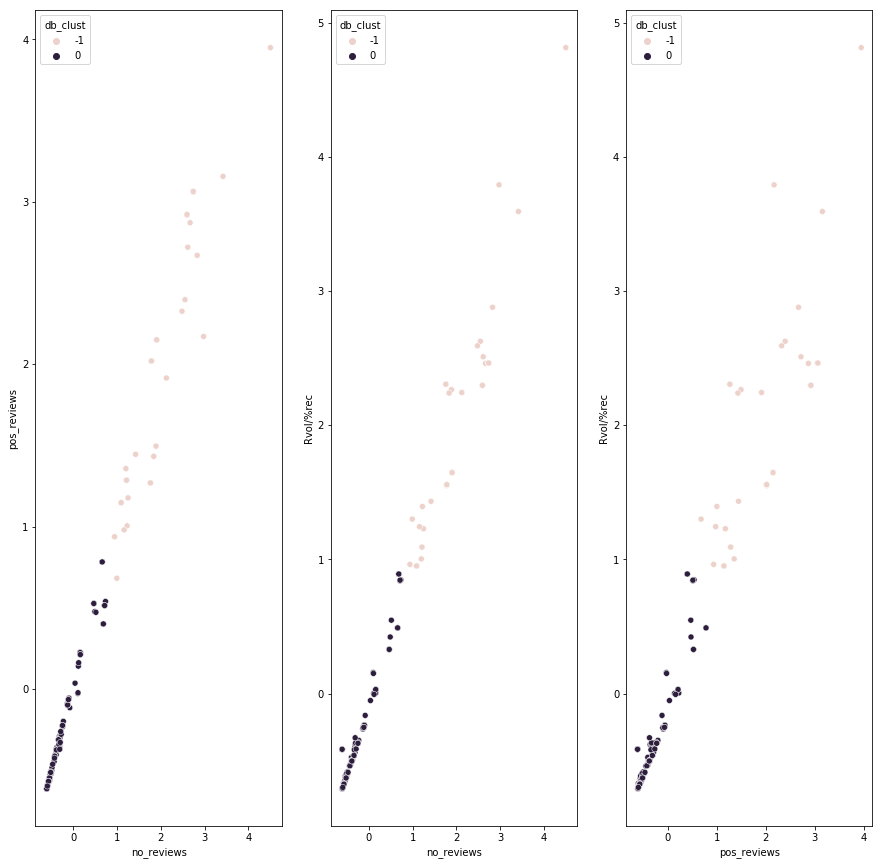

In [31]:
phones['db_clust'] = pd.Series(db_clust, index=phones.index)
f, axes = plt.subplots(1,3, figsize=(15,15))
sns.scatterplot(x=phones['no_reviews'], y=phones['pos_reviews'], hue=phones['db_clust'],ax=axes[0])
sns.scatterplot(x=phones['no_reviews'], y=phones['Rvol/%rec'],hue=phones['db_clust'], ax=axes[1])
sns.scatterplot(x=phones['pos_reviews'], y=phones['Rvol/%rec'],hue=phones['db_clust'], ax=axes[2])

## desktops

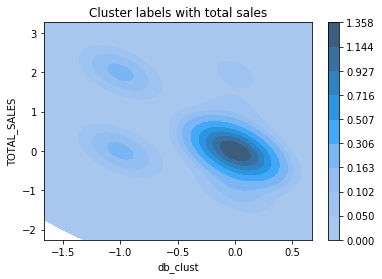

In [32]:

dbscan_model = DBSCAN(eps=1.2, min_samples=(len(desktops))/5)
db_clust = dbscan_model.fit_predict(desktops[['no_reviews','Rvol/%rec','pos_reviews']])
desktops['db_clust'] = pd.Series(db_clust, index=desktops.index)
evaluate_clusters(desktops['db_clust'] ,desktops['TOTAL_SALES'])

In [33]:
cluster_intelligence.cluster_report(desktops[['no_reviews','Rvol/%rec','pos_reviews']],db_clust)

,class_name,instance_count,rule_list
1,-1,6,NaN
0,0,26,[0.8125] ALL


In [34]:
get_eval_scores(desktops['y_true'], desktops['db_clust'])

(0.5, 0.6)

In [35]:
print(desktops.loc[desktops.db_clust==-1]['TOTAL_SALES'].mean())
print(desktops.loc[desktops.db_clust==-0]['TOTAL_SALES'].mean())

1.0261998611641638
-0.23681535257634556


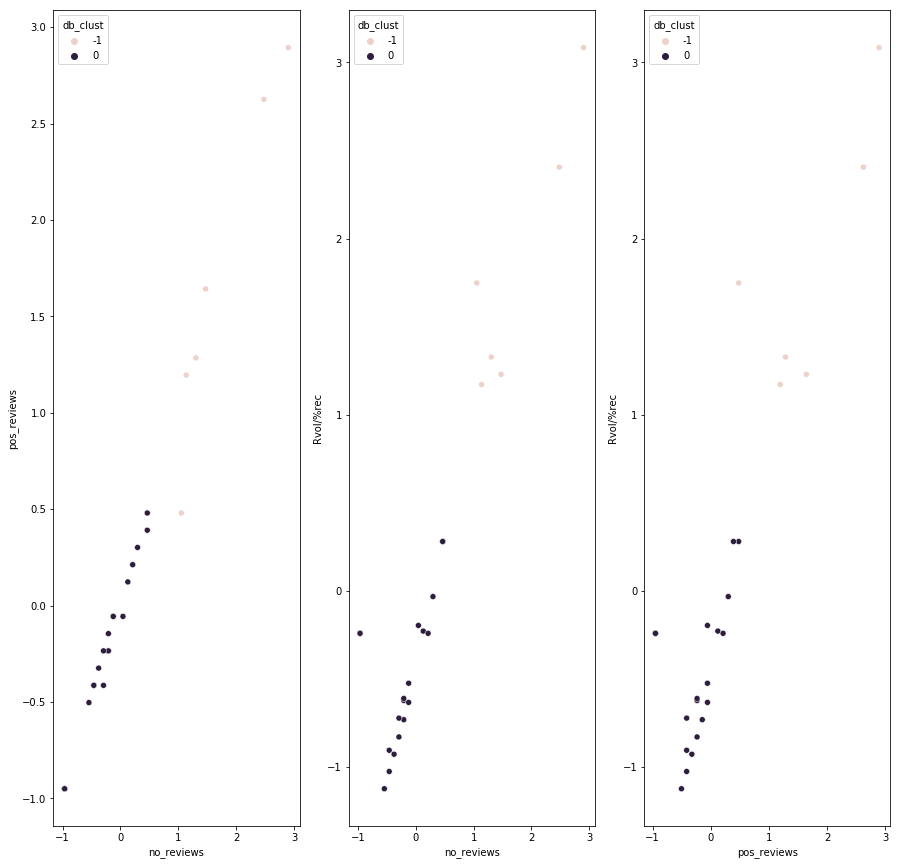

In [37]:
desktops['db_clust'] = pd.Series(db_clust, index=desktops.index)
f, axes = plt.subplots(1,3, figsize=(15,15))
sns.scatterplot(x=desktops['no_reviews'], y=desktops['pos_reviews'], hue=desktops['db_clust'],ax=axes[0])
sns.scatterplot(x=desktops['no_reviews'], y=desktops['Rvol/%rec'],hue=desktops['db_clust'], ax=axes[1])
sns.scatterplot(x=desktops['pos_reviews'], y=desktops['Rvol/%rec'],hue=desktops['db_clust'], ax=axes[2])

## tablets

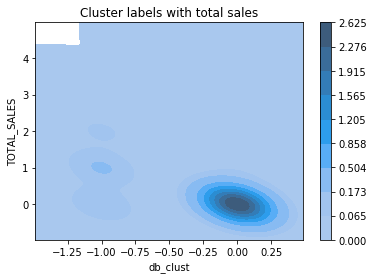

In [39]:

dbscan_model = DBSCAN(eps=1.2, min_samples=(len(tablets))/5)
db_clust = dbscan_model.fit_predict(tablets[['no_reviews','Rvol/%rec','pos_reviews']])
tablets['db_clust'] = pd.Series(db_clust, index=tablets.index)
evaluate_clusters(tablets['db_clust'] ,tablets['TOTAL_SALES'])

In [41]:
cluster_intelligence.cluster_report(tablets[['no_reviews','Rvol/%rec','pos_reviews']],db_clust)

,class_name,instance_count,rule_list
1,-1,11,NaN
0,0,73,[0.8690476190476191] ALL


In [42]:
get_eval_scores(tablets['y_true'], tablets['db_clust'])

(0.6363636363636364, 0.6363636363636364)

In [43]:
print(tablets.loc[tablets.db_clust==-1]['TOTAL_SALES'].mean())
print(tablets.loc[tablets.db_clust==-0]['TOTAL_SALES'].mean())

1.2792104284931283
-0.19275773580033434


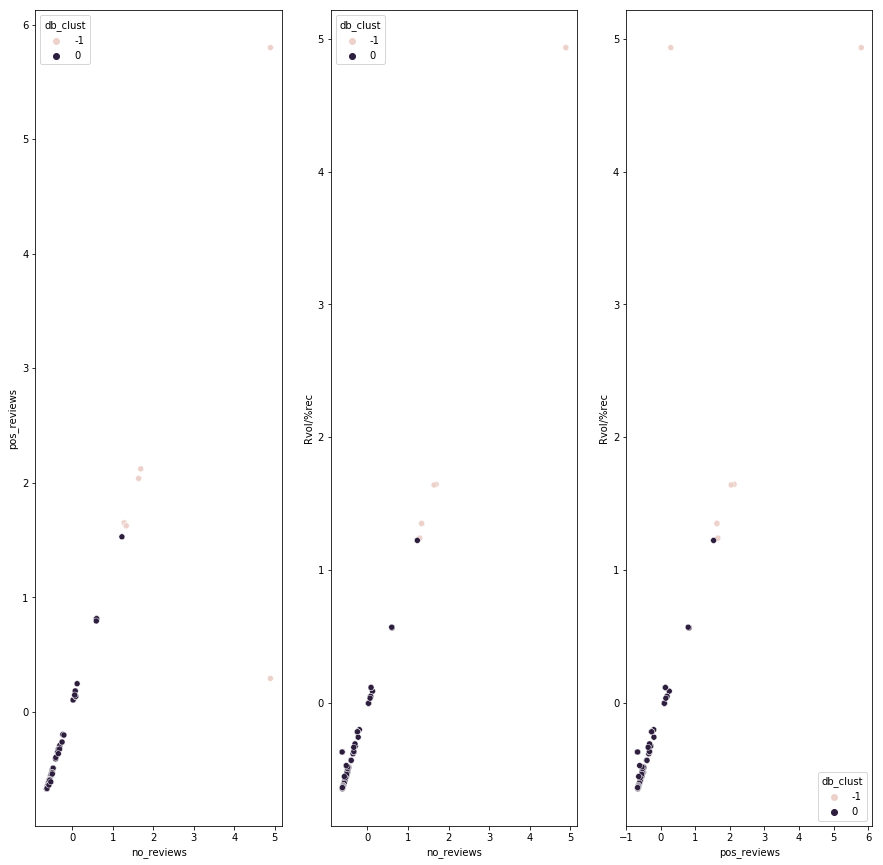

In [44]:
tablets['db_clust'] = pd.Series(db_clust, index=tablets.index)
f, axes = plt.subplots(1,3, figsize=(15,15))
sns.scatterplot(x=tablets['no_reviews'], y=tablets['pos_reviews'], hue=tablets['db_clust'],ax=axes[0])
sns.scatterplot(x=tablets['no_reviews'], y=tablets['Rvol/%rec'],hue=tablets['db_clust'], ax=axes[1])
sns.scatterplot(x=tablets['pos_reviews'], y=tablets['Rvol/%rec'],hue=tablets['db_clust'], ax=axes[2])